# Import packages and data 'CarPrice_Assignment.csv' from Kaggle
### https://www.kaggle.com/datasets/hellbuoy/car-price-prediction

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f,norm,sem
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.weightstats as sms
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from timeit import default_timer as timer
from sklearn.inspection import permutation_importance

C:\Users\kavan\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('CarPrice_Assignment.csv')
#Set view columns to max to avoid truncated data
pd.set_option('display.max_columns', None)

dictionary = pd.read_excel('Data Dictionary - carprices.xlsx')
dictionary = dictionary[['Unnamed: 7','Unnamed: 11']]

In [4]:
df.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [5]:
dictionary = dictionary.dropna()
col_names = ['Variable', 'Description']
dictionary.columns = col_names
dictionary.head()

,Variable,Description
3,Car_ID,Unique id of each observation (Interger)
4,Symboling,"Its assigned insurance risk rating, A value of..."
5,carCompany,Name of car company (Categorical)
6,fueltype,Car fuel type i.e gas or diesel (Categorical)
7,aspiration,Aspiration used in a car (Categorical)


# Check Data and Clean

In [6]:
#Check for missing values
df.isnull().sum()

car_ID              0
symboling           0
CarName             0
fueltype            0
aspiration          0
doornumber          0
carbody             0
drivewheel          0
enginelocation      0
wheelbase           0
carlength           0
carwidth            0
carheight           0
curbweight          0
enginetype          0
cylindernumber      0
enginesize          0
fuelsystem          0
boreratio           0
stroke              0
compressionratio    0
horsepower          0
peakrpm             0
citympg             0
highwaympg          0
price               0
dtype: int64

In [7]:
#Make new df for cleaned data, keep a copy of the original df if needed later
dfc = df.copy()

In [8]:
#Car_ID is unique for each car so it is dropped
dfc = dfc.drop('car_ID',axis=1)

In [9]:
dfc.dtypes

symboling             int64
CarName              object
fueltype             object
aspiration           object
doornumber           object
carbody              object
drivewheel           object
enginelocation       object
wheelbase           float64
carlength           float64
carwidth            float64
carheight           float64
curbweight            int64
enginetype           object
cylindernumber       object
enginesize            int64
fuelsystem           object
boreratio           float64
stroke              float64
compressionratio    float64
horsepower            int64
peakrpm               int64
citympg               int64
highwaympg            int64
price               float64
dtype: object

In [10]:
#Symboling is not continous data but categorical, see data dictionary, change to object.
dfc['symboling'] = dfc['symboling'].astype(str)

#### Clean Car Names

In [11]:
dfc['CarName'].unique()

array(['alfa-romero giulia', 'alfa-romero stelvio',
       'alfa-romero Quadrifoglio', 'audi 100 ls', 'audi 100ls',
       'audi fox', 'audi 5000', 'audi 4000', 'audi 5000s (diesel)',
       'bmw 320i', 'bmw x1', 'bmw x3', 'bmw z4', 'bmw x4', 'bmw x5',
       'chevrolet impala', 'chevrolet monte carlo', 'chevrolet vega 2300',
       'dodge rampage', 'dodge challenger se', 'dodge d200',
       'dodge monaco (sw)', 'dodge colt hardtop', 'dodge colt (sw)',
       'dodge coronet custom', 'dodge dart custom',
       'dodge coronet custom (sw)', 'honda civic', 'honda civic cvcc',
       'honda accord cvcc', 'honda accord lx', 'honda civic 1500 gl',
       'honda accord', 'honda civic 1300', 'honda prelude',
       'honda civic (auto)', 'isuzu MU-X', 'isuzu D-Max ',
       'isuzu D-Max V-Cross', 'jaguar xj', 'jaguar xf', 'jaguar xk',
       'maxda rx3', 'maxda glc deluxe', 'mazda rx2 coupe', 'mazda rx-4',
       'mazda glc deluxe', 'mazda 626', 'mazda glc', 'mazda rx-7 gs',
       'mazda glc 

In [12]:
#There is few cars of the same model so I will replace the full car name with just the brand

#First make an array of all car brands in column

brands = ['alfa-romero','audi','bmw','chevrolet','dodge','honda','isuzu','jaguar','mazda','buick',
          'mercury','mitsubishi','nissan','peugeot','plymouth','porsche','renault','saab','subaru',
          'toyota','volkswagen','volvo']
list1 = df.CarName.unique()

#Use a loop to search for strings that contain a brand name and replace string with brand name, i.e. removing model name.

for i in range(len(brands)):
    brand = brands[i]
    l1 = [k for k in list1 if brand in k]
    dfc = dfc.replace(l1,brand)
    
#Replacing misspelled names manually

dfc = dfc.replace(['Nissan versa'], 'nissan')
dfc = dfc.replace(['vokswagen rabbit'], 'volkswagen')
dfc = dfc.replace(['porcshce panamera'], 'porsche')
dfc = dfc.replace([ 'maxda rx3', 'maxda glc deluxe'],'mazda')
dfc = dfc.replace(['toyouta tercel'],'toyota')
dfc = dfc.replace(['vw dasher','vw rabbit'],'volkswagen')

In [13]:
dfc['CarName'].value_counts()

toyota         32
nissan         18
mazda          17
mitsubishi     13
honda          13
volkswagen     12
subaru         12
peugeot        11
volvo          11
dodge           9
bmw             8
buick           7
audi            7
plymouth        7
saab            6
isuzu           5
porsche         5
jaguar          3
chevrolet       3
alfa-romero     3
renault         2
mercury         1
Name: CarName, dtype: int64

#### Checking other categorical variables

In [14]:
dfc['enginelocation'].value_counts()

front    202
rear       3
Name: enginelocation, dtype: int64

In [15]:
dfc['symboling'].value_counts()

0     67
1     54
2     32
3     27
-1    22
-2     3
Name: symboling, dtype: int64

In [16]:
dfc['doornumber'].value_counts()

four    115
two      90
Name: doornumber, dtype: int64

In [17]:
dfc['enginetype'].value_counts()

ohc      148
ohcf      15
ohcv      13
dohc      12
l         12
rotor      4
dohcv      1
Name: enginetype, dtype: int64

In [18]:
dfc['aspiration'].value_counts()

std      168
turbo     37
Name: aspiration, dtype: int64

In [19]:
dfc['cylindernumber'].value_counts()

four      159
six        24
five       11
eight       5
two         4
three       1
twelve      1
Name: cylindernumber, dtype: int64

In [20]:
#The vast majority of cars are front engine, this will not help in regression so is dropped
dfc = dfc.drop('enginelocation',axis=1)

In [21]:
#Making a copy of the cleaned data.
df_cleaned = dfc.copy()

In [22]:
np.round(df.corr(),2)

,car_ID,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
car_ID,1.00,-0.15,0.13,0.17,0.05,0.26,0.07,-0.03,0.26,-0.16,0.15,-0.02,-0.20,0.02,0.01,-0.11
symboling,-0.15,1.00,-0.53,-0.36,-0.23,-0.54,-0.23,-0.11,-0.13,-0.01,-0.18,0.07,0.27,-0.04,0.03,-0.08
wheelbase,0.13,-0.53,1.00,0.87,0.80,0.59,0.78,0.57,0.49,0.16,0.25,0.35,-0.36,-0.47,-0.54,0.58
carlength,0.17,-0.36,0.87,1.00,0.84,0.49,0.88,0.68,0.61,0.13,0.16,0.55,-0.29,-0.67,-0.70,0.68
carwidth,0.05,-0.23,0.80,0.84,1.00,0.28,0.87,0.74,0.56,0.18,0.18,0.64,-0.22,-0.64,-0.68,0.76
carheight,0.26,-0.54,0.59,0.49,0.28,1.00,0.30,0.07,0.17,-0.06,0.26,-0.11,-0.32,-0.05,-0.11,0.12
curbweight,0.07,-0.23,0.78,0.88,0.87,0.30,1.00,0.85,0.65,0.17,0.15,0.75,-0.27,-0.76,-0.80,0.84
enginesize,-0.03,-0.11,0.57,0.68,0.74,0.07,0.85,1.00,0.58,0.20,0.03,0.81,-0.24,-0.65,-0.68,0.87
boreratio,0.26,-0.13,0.49,0.61,0.56,0.17,0.65,0.58,1.00,-0.06,0.01,0.57,-0.25,-0.58,-0.59,0.55
stroke,-0.16,-0.01,0.16,0.13,0.18,-0.06,0.17,0.20,-0.06,1.00,0.19,0.08,-0.07,-0.04,-0.04,0.08


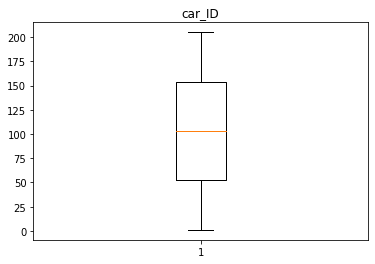

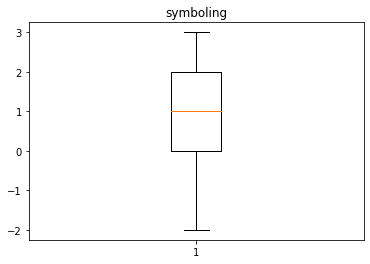

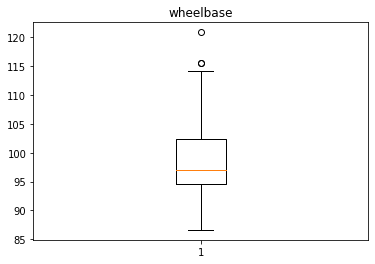

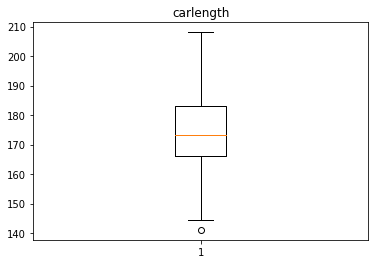

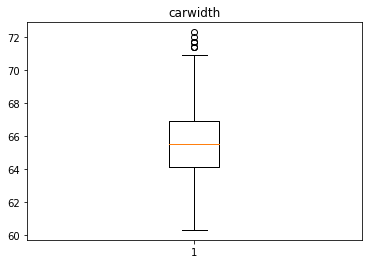

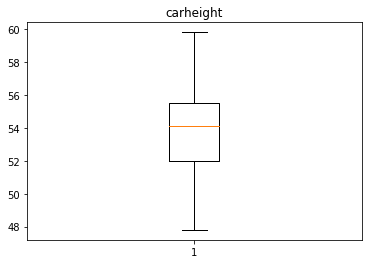

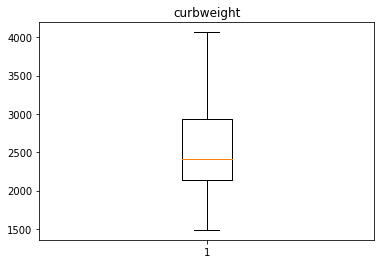

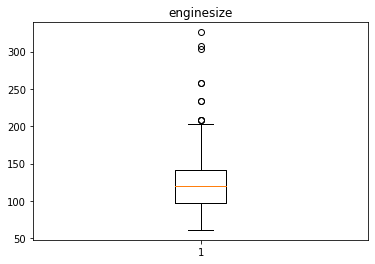

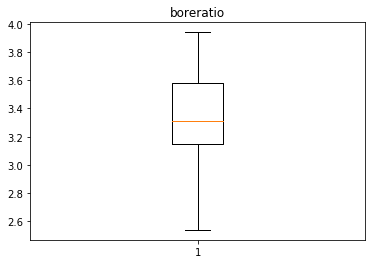

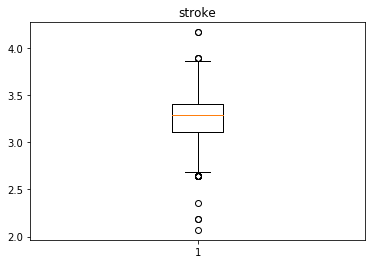

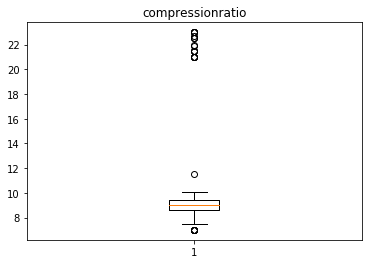

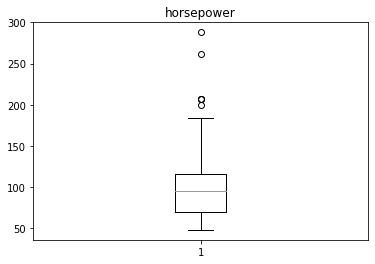

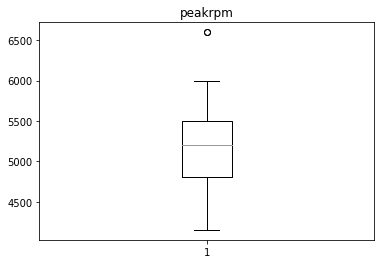

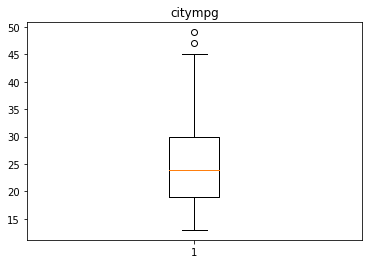

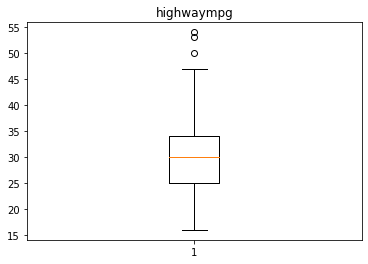

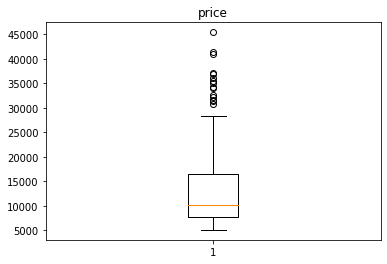

In [23]:
#Get all numeric data columns and use boxpplots to check for skewed data.
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

numericdf = df.select_dtypes(include=numerics)

for i in range(len(numericdf.columns)):
    plt.boxplot(numericdf[numericdf.columns[i]])
    plt.title(numericdf.columns[i])
    plt.show()

#### Price looks skewed, may use the log 10 function in MLR model.

# Data Exploration

## Is there a difference in mpg based on fuel types ?

In [24]:
#Make a new column for average mpg, take the mean average of city and highway mpg combined.
dfc['averagempg'] = (dfc['citympg'] + dfc['highwaympg'])/2

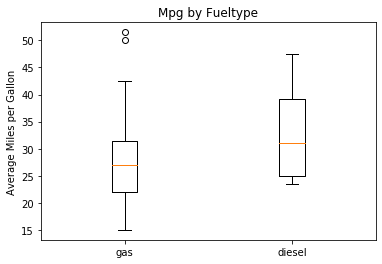

Gas mean average mpg:  27.494594594594595 
from sample size:  185

Diesel mean average mpg:  32.525 
from sample size:  20


In [25]:
#Visualise the data on a boxplot

#Split the data into gas and diesel
gasmpg = dfc[dfc['fueltype']=='gas']['averagempg']
dieselmpg = dfc[dfc['fueltype']=='diesel']['averagempg']

#Plotting on boxplot
plt.boxplot([gasmpg.values,dieselmpg.values])
plt.xticks([1,2],['gas','diesel'])
plt.ylabel('Average Miles per Gallon')
plt.title('Mpg by Fueltype')
plt.show()

print('Gas mean average mpg: ',gasmpg.mean(), '\nfrom sample size: ', len(gasmpg))
print('\nDiesel mean average mpg: ',dieselmpg.mean(), '\nfrom sample size: ', len(dieselmpg))

In [26]:
dfc['averagempg'].idxmax()

30

In [27]:
df.iloc[30,:]

car_ID                       31
symboling                     2
CarName             honda civic
fueltype                    gas
aspiration                  std
doornumber                  two
carbody               hatchback
drivewheel                  fwd
enginelocation            front
wheelbase                  86.6
carlength                 144.6
carwidth                   63.9
carheight                  50.8
curbweight                 1713
enginetype                  ohc
cylindernumber             four
enginesize                   92
fuelsystem                 1bbl
boreratio                  2.91
stroke                     3.41
compressionratio            9.6
horsepower                   58
peakrpm                    4800
citympg                      49
highwaympg                   54
price                    6479.0
Name: 30, dtype: object

In [28]:
#Fisher's F test
var_gas = np.var(gasmpg,ddof=1)
var_diesel = np.var(dieselmpg,ddof=1)
print(var_gas)
print(var_diesel)

40.885840188014114
57.11776315789475


In [29]:
f_ratio = var_diesel/var_gas
print(f_ratio)

1.3970059779923296


In [30]:
#Get p value for difference in variances
dfn = len(dieselmpg)-1
dfd = len(gasmpg)-1
alpha = 0.05
p_one_tailed = f.sf(f_ratio, dfn, dfd)
p = p_one_tailed * 2
print('pvalue is: ',p)
if p < alpha:
    print('Reject the null hypothesis that variances of the samples are equal')
else:
    print('Null hypothesis cannot be rejected')

pvalue is:  0.26503683887909263
Null hypothesis cannot be rejected


In [31]:
#Use a pooled standard deviation to perform t-test
stats.ttest_ind(a = gasmpg, b = dieselmpg, equal_var=True)

Ttest_indResult(statistic=-3.281844150086013, pvalue=0.0012140801976620824)

In [32]:
cm = sms.CompareMeans(sms.DescrStatsW(gasmpg), sms.DescrStatsW(dieselmpg))
print(cm.tconfint_diff(usevar='pooled'))

(-8.052652867393986, -2.008157943416821)


#### At 0.05 significance diesel cars get between 2.01 and 8.05 more mpg than gas. However, a gas Honda Civic has the best average
#### mpg in the sample.

#### Visualise distribution of drivewheels by carbody type

In [33]:
#Define a funciton to print the value counts of drivewheels by carbody type
def get(name):
    a = dfc[dfc['carbody']==name]['drivewheel']
    print(name,' have the following drivewheels\n',a.value_counts(), '\n \n')

#Use a loop to put each carbody type through the above function

for i in range(len(dfc['carbody'].unique())):
    get(dfc['carbody'].unique()[i])

convertible  have the following drivewheels
 rwd    5
fwd    1
Name: drivewheel, dtype: int64 
 

hatchback  have the following drivewheels
 fwd    49
rwd    19
4wd     2
Name: drivewheel, dtype: int64 
 

sedan  have the following drivewheels
 fwd    57
rwd    36
4wd     3
Name: drivewheel, dtype: int64 
 

wagon  have the following drivewheels
 fwd    12
rwd     9
4wd     4
Name: drivewheel, dtype: int64 
 

hardtop  have the following drivewheels
 rwd    7
fwd    1
Name: drivewheel, dtype: int64 
 



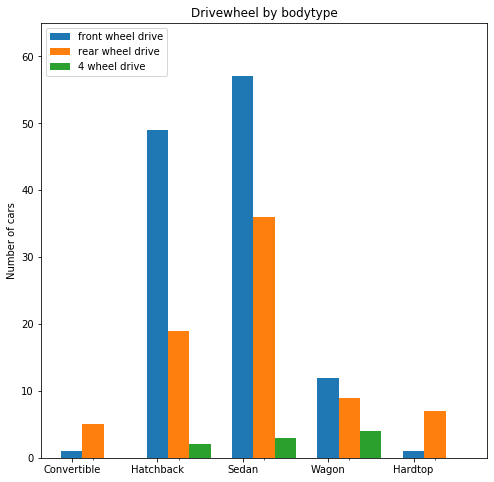

In [34]:
#Organise results into categories and frequency
body = ("Convertible", "Hatchback", "Sedan","Wagon","Hardtop")
count = {
    'front wheel drive': (1,49,57,12,1),
    'rear wheel drive': (5,19,36,9,7),
    '4 wheel drive': (0,2,3,4,0),
}

x = np.arange(len(body))
width = 0.25
multiplier = 0

#Plot grouped bar chart
fig, ax = plt.subplots(figsize =(8,8))

for attribute, measurement in count.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    multiplier += 1



ax.set_ylabel('Number of cars')
ax.set_title('Drivewheel by bodytype')
ax.set_xticks(x + width, body)
ax.legend(loc='upper left')
ax.set_ylim(0, 65)
ax.set_xticklabels(["0","Convertible", "Hatchback", "Sedan","Wagon","Hardtop"])

plt.show()

#### Hatchbacks and Sedans are predominantely front wheel drive. They are also the most common car body type in the sample.
#### Convertibles and Hardtops are predominantely rear wheel drive, although the samples are small (n < 10)
#### Wagons have a mix of all 3 drivewheels.

## What are the best and worst performing cars in the data ?

In [35]:
#Horsepower is a good metric to use to determine performance.
#However, power to weight ratio is a better metric for sports car perfomance as a car that has a high
#horsepower but is heavy will be slow.

#Make new column with power to weight ratio (horsepower / curbweight) multiplied by 2000 to convert lbs to US ton.
#Unit horsepower per US ton.


dfc['bhp/weight'] = (dfc['horsepower']/dfc['curbweight'])*2000

In [36]:
#Find the largest values in new column created
dfc['bhp/weight'].nlargest(n=5)

129    171.122995
126    150.217707
127    150.217707
128    147.857143
49     132.658228
Name: bhp/weight, dtype: float64

In [37]:
#Make a list of the index of the cars with best power to weight ratio
best = dfc['bhp/weight'].nlargest(n=5).index.values

In [38]:
print('Best performing cars\n')
#Use the original dataframe to get full name of the top 5 performing cars
for i in range(5):
    print(i+1, df['CarName'].iloc[best[i]], 'has a power to weight ratio of:' , round(dfc['bhp/weight'].iloc[best[i]],1), 'bhp per US ton. Price : ', df['price'].iloc[best[i]], ' USD\n')

Best performing cars

1 porsche cayenne has a power to weight ratio of: 171.1 bhp per US ton. Price :  31400.5  USD

2 porcshce panamera has a power to weight ratio of: 150.2 bhp per US ton. Price :  32528.0  USD

3 porsche cayenne has a power to weight ratio of: 150.2 bhp per US ton. Price :  34028.0  USD

4 porsche boxter has a power to weight ratio of: 147.9 bhp per US ton. Price :  37028.0  USD

5 jaguar xk has a power to weight ratio of: 132.7 bhp per US ton. Price :  36000.0  USD



In [39]:
print('Worst performing cars\n')
#Repeat steps above for the worst cars
worst = dfc['bhp/weight'].nsmallest(n=5).index.values
for i in range(5):
    print(i+1, df['CarName'].iloc[worst[i]], 'has a power to weight ratio of:' , round(dfc['bhp/weight'].iloc[worst[i]],1), 'bhp per US ton. Price : ', df['price'].iloc[worst[i]], ' USD\n')

Worst performing cars

1 toyota carina has a power to weight ratio of: 39.9 bhp per US ton. Price :  8778.0  USD

2 volkswagen model 111 has a power to weight ratio of: 45.9 bhp per US ton. Price :  7995.0  USD

3 vokswagen rabbit has a power to weight ratio of: 46.0 bhp per US ton. Price :  7775.0  USD

4 toyota corona has a power to weight ratio of: 49.2 bhp per US ton. Price :  7898.0  USD

5 toyota corolla has a power to weight ratio of: 49.2 bhp per US ton. Price :  7788.0  USD



## Which brands have the best insurance ratings ? ('symboling', +3 is risky, -3 is very safe)

In [40]:
#Create blank DataFrame for normalised symbol counts
dfs = pd.DataFrame({'Blank': [0]}, index =['-2','-1','0','1','2','3'])

In [41]:
#Create a loop that adds a new column for each brand containing the normalised value counts
for i in range(len(brands)):
    symb = dfc[dfc['CarName']== brands[i]]['symboling']
    dfs[brands[i]] = symb.value_counts(normalize=True, dropna = False)

In [42]:
#Drop blank
dfs1 = dfs.drop('Blank',axis=1)
#Transpose data frame and plot with color gradient. Red is risky, blue is safe.
dfs1 = dfs1.T
#Sort data by which brand has the highest percetage of good symbols.
dfs1 = dfs1.sort_values(by=['-2','-1','0','1'],ascending=False)

#Convert normalise to percentage
dfs1 = dfs1 * 100

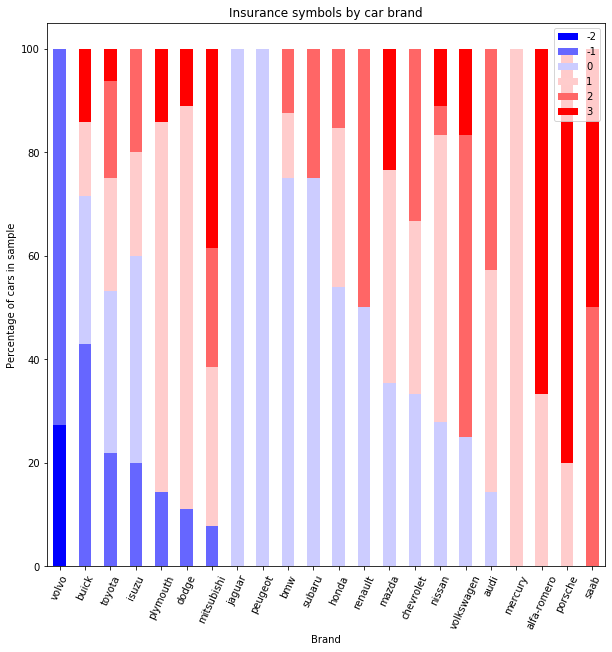

In [43]:
dfs1.plot(
    kind = 'bar',
    stacked = True,
    title = 'Insurance symbols by car brand',
    mark_right = True,
    colormap='bwr',
    rot=65,
    figsize = (10,10),
    ylabel= 'Percentage of cars in sample',
    xlabel= 'Brand')

#### Volvo has the best insurance ratings while Saab has the worst in our given sample

## Do different drivewheels tend to have a difference in horsepower ?

In [44]:
dfcyl = df_cleaned.copy()

In [45]:
#split data
rwd = dfcyl[dfcyl['drivewheel']=='rwd']['horsepower']
fwd = dfcyl[dfcyl['drivewheel']=='fwd']['horsepower']
fourwd = dfcyl[dfcyl['drivewheel']=='4wd']['horsepower']

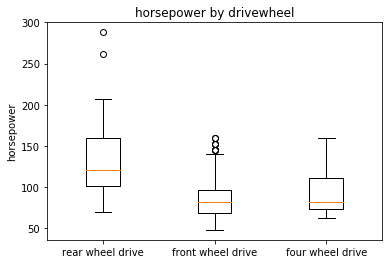

In [46]:
#Plotting on boxplot
plt.boxplot([rwd.values,fwd.values,fourwd.values])
plt.xticks([1,2,3],['rear wheel drive','front wheel drive','four wheel drive'])
plt.ylabel('horsepower')
plt.title('horsepower by drivewheel')
plt.show()

#### Rear wheel drive may have slightly more horsepower. Use an ANOVA test to find if the means of the grouped data are different.

In [47]:
f_oneway(rwd, fwd, fourwd)

F_onewayResult(statistic=50.54700453337045, pvalue=1.5891896935120314e-18)

#### There is statistical difference between the means of at least two of the groups.

In [48]:
#perform Tukey post-hoc test.
print(pairwise_tukeyhsd(endog=dfcyl['horsepower'],
                        groups=dfcyl['drivewheel'],
                        alpha=0.05))

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
   4wd    fwd  -9.2917 0.6704 -35.7669 17.1835  False
   4wd    rwd   38.364 0.0027  11.3595 65.3686   True
   fwd    rwd  47.6557  0.001  36.4255 58.8859   True
-----------------------------------------------------


#### Rwd has 38.4 and 47.7 hp more than 4wd and fwd respectively at 0.05 significance.

# Make MLR model

In [49]:
#Include all numeric and categorical variables for MLR model.
#New df for the model, dfm.

dfm = df_cleaned.copy()

In [50]:
dfm = pd.get_dummies(dfm, drop_first=True)


In [51]:
dfm.columns

Index(['wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight',
       'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
       'peakrpm', 'citympg', 'highwaympg', 'price', 'symboling_-2',
       'symboling_0', 'symboling_1', 'symboling_2', 'symboling_3',
       'CarName_audi', 'CarName_bmw', 'CarName_buick', 'CarName_chevrolet',
       'CarName_dodge', 'CarName_honda', 'CarName_isuzu', 'CarName_jaguar',
       'CarName_mazda', 'CarName_mercury', 'CarName_mitsubishi',
       'CarName_nissan', 'CarName_peugeot', 'CarName_plymouth',
       'CarName_porsche', 'CarName_renault', 'CarName_saab', 'CarName_subaru',
       'CarName_toyota', 'CarName_volkswagen', 'CarName_volvo', 'fueltype_gas',
       'aspiration_turbo', 'doornumber_two', 'carbody_hardtop',
       'carbody_hatchback', 'carbody_sedan', 'carbody_wagon', 'drivewheel_fwd',
       'drivewheel_rwd', 'enginetype_dohcv', 'enginetype_l', 'enginetype_ohc',
       'enginetype_ohcf', 'enginetype_ohcv', 'engine

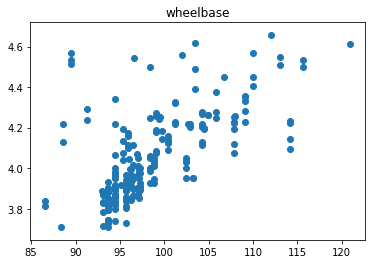

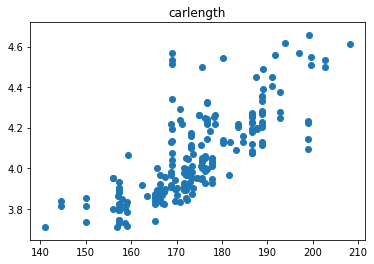

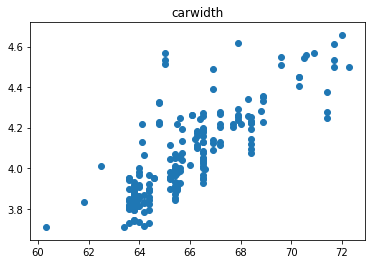

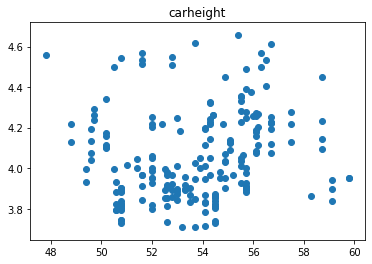

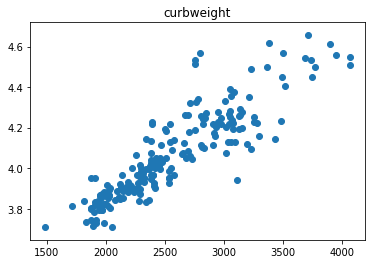

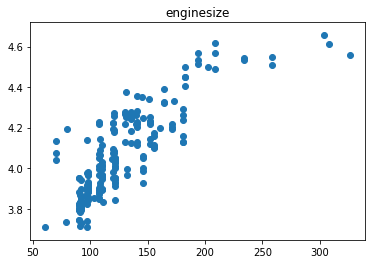

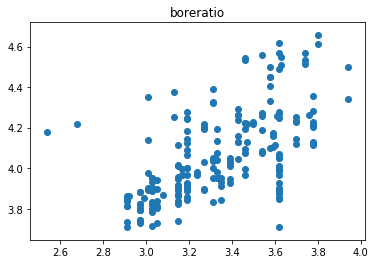

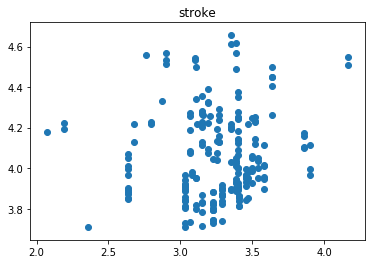

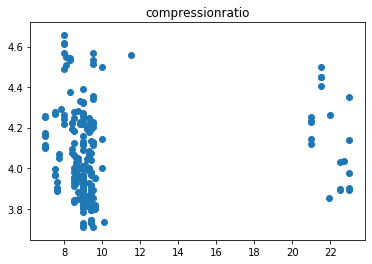

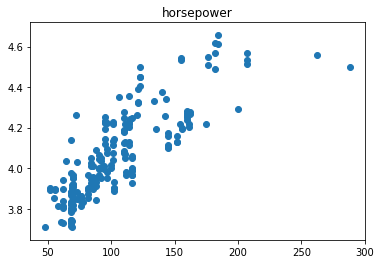

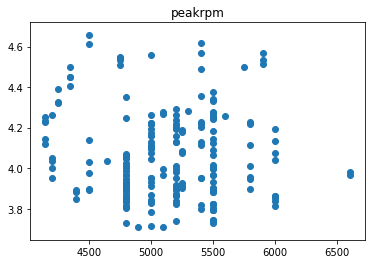

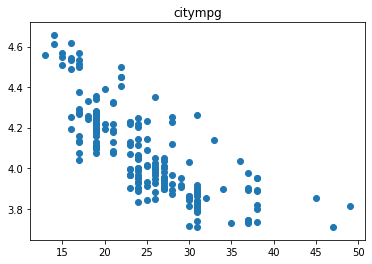

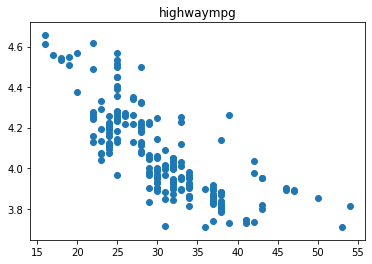

In [52]:
#Use scatter graphs to find relationship between variables and log10 of the price.

dfm = pd.get_dummies(dfm, drop_first = True)

for i in range(13):
    plt.scatter(dfm[dfm.columns[i]], np.log10(dfm['price']))
    plt.title(dfm.columns[i])
    plt.show()

In [53]:
#Looks like a strong correlation between carwidth, curbweight, horsepower, enginesize and city mpg with log 10 of the price.
#Make a model with these variables
X = dfm[['carwidth','curbweight','horsepower','enginesize','citympg']]
X = sm.add_constant(X)

dfm['log10 price'] = np.log10(dfm['price'])
y = dfm['log10 price']


In [54]:
#Define a function to make a MLR model an print a summary of results. 


regr = linear_model.LinearRegression()

def get_stats():
    regr.fit(X, y)
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X) 

    print_model = model.summary()
    print(print_model)

In [55]:
get_stats()

                            OLS Regression Results                            
Dep. Variable:            log10 price   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     238.8
Date:                Mon, 29 May 2023   Prob (F-statistic):           4.94e-82
Time:                        13:36:53   Log-Likelihood:                 220.59
No. Observations:                 205   AIC:                            -429.2
Df Residuals:                     199   BIC:                            -409.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5179      0.321      7.834      0.0

#### Remove variable with highest p value, re-run model and repeat until all variables have p less than 0.05.

In [56]:
X = dfm[['carwidth','curbweight','horsepower','enginesize']]
X = sm.add_constant(X)
get_stats()

                            OLS Regression Results                            
Dep. Variable:            log10 price   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     296.8
Date:                Mon, 29 May 2023   Prob (F-statistic):           6.69e-83
Time:                        13:36:53   Log-Likelihood:                 219.65
No. Observations:                 205   AIC:                            -429.3
Df Residuals:                     200   BIC:                            -412.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4191      0.314      7.712      0.0

In [57]:
X = dfm[['carwidth','curbweight','horsepower']]
X = sm.add_constant(X)
get_stats()

                            OLS Regression Results                            
Dep. Variable:            log10 price   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     395.5
Date:                Mon, 29 May 2023   Prob (F-statistic):           5.03e-84
Time:                        13:36:53   Log-Likelihood:                 219.15
No. Observations:                 205   AIC:                            -430.3
Df Residuals:                     201   BIC:                            -417.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4074      0.313      7.681      0.0

In [58]:
#drop car width to reduce multicollinearity
X = X.drop('carwidth', axis = 1)
get_stats()

                            OLS Regression Results                            
Dep. Variable:            log10 price   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     575.1
Date:                Mon, 29 May 2023   Prob (F-statistic):           4.05e-84
Time:                        13:36:53   Log-Likelihood:                 216.01
No. Observations:                 205   AIC:                            -426.0
Df Residuals:                     202   BIC:                            -416.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.1883      0.031    101.954      0.0

<Figure size 864x576 with 0 Axes>

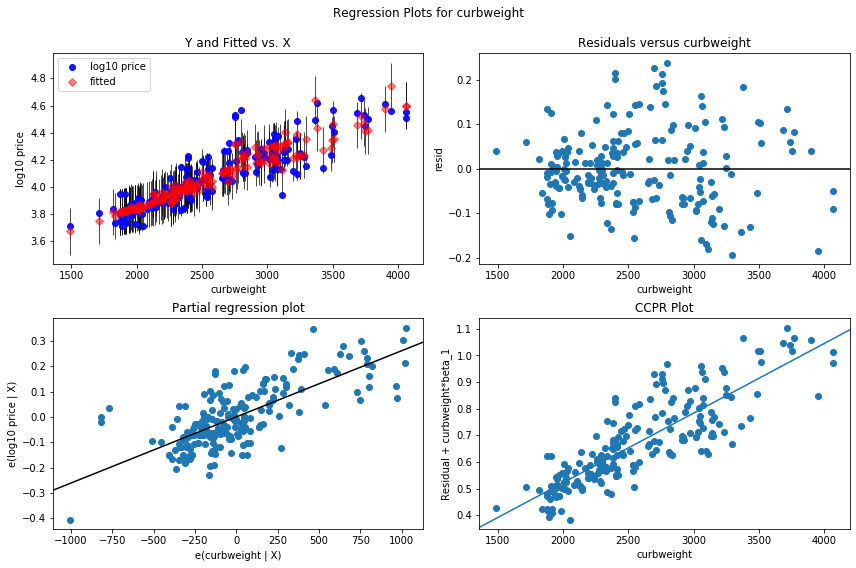

In [59]:
fig = plt.figure(figsize = (12, 8))

model = sm.OLS(y, X).fit()

fig = plt.figure(figsize = (12, 8))
fig = sm.graphics.plot_regress_exog(model, 'curbweight', fig = fig)
plt.show()

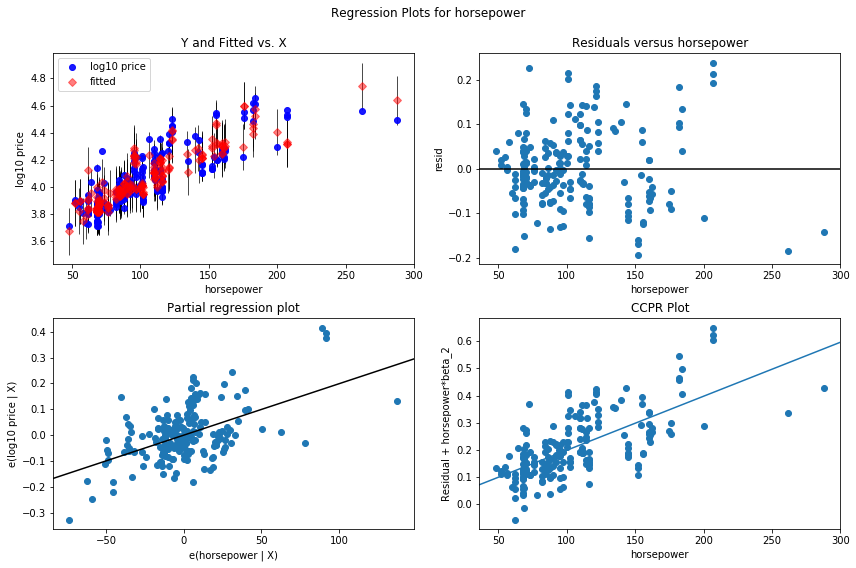

In [60]:
fig = plt.figure(figsize = (12, 8))
fig = sm.graphics.plot_regress_exog(model, 'horsepower', fig = fig)
plt.show()

#### Horsepower is right skewed, try log10 for horsepower.

In [61]:
X['log10 horsepower'] = np.log10(X['horsepower'])
X = X.drop('horsepower', axis = 1)

In [62]:
get_stats()

                            OLS Regression Results                            
Dep. Variable:            log10 price   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     571.4
Date:                Mon, 29 May 2023   Prob (F-statistic):           7.02e-84
Time:                        13:36:57   Log-Likelihood:                 215.45
No. Observations:                 205   AIC:                            -424.9
Df Residuals:                     202   BIC:                            -414.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                2.3261      0.095  

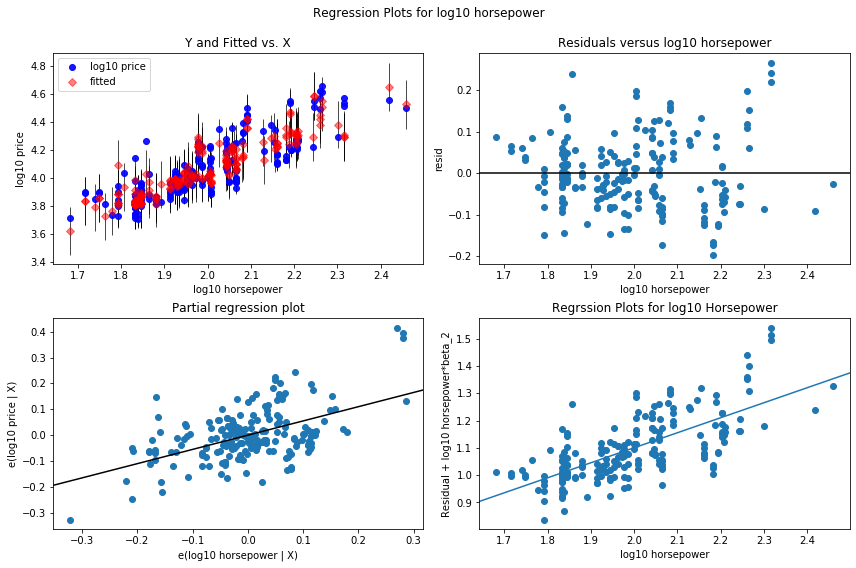

In [63]:
fig = plt.figure(figsize = (12, 8))

model = sm.OLS(y, X).fit()

fig = sm.graphics.plot_regress_exog(model, 'log10 horsepower', fig = fig)
plt.title('Regrssion Plots for log10 Horsepower')
plt.show()

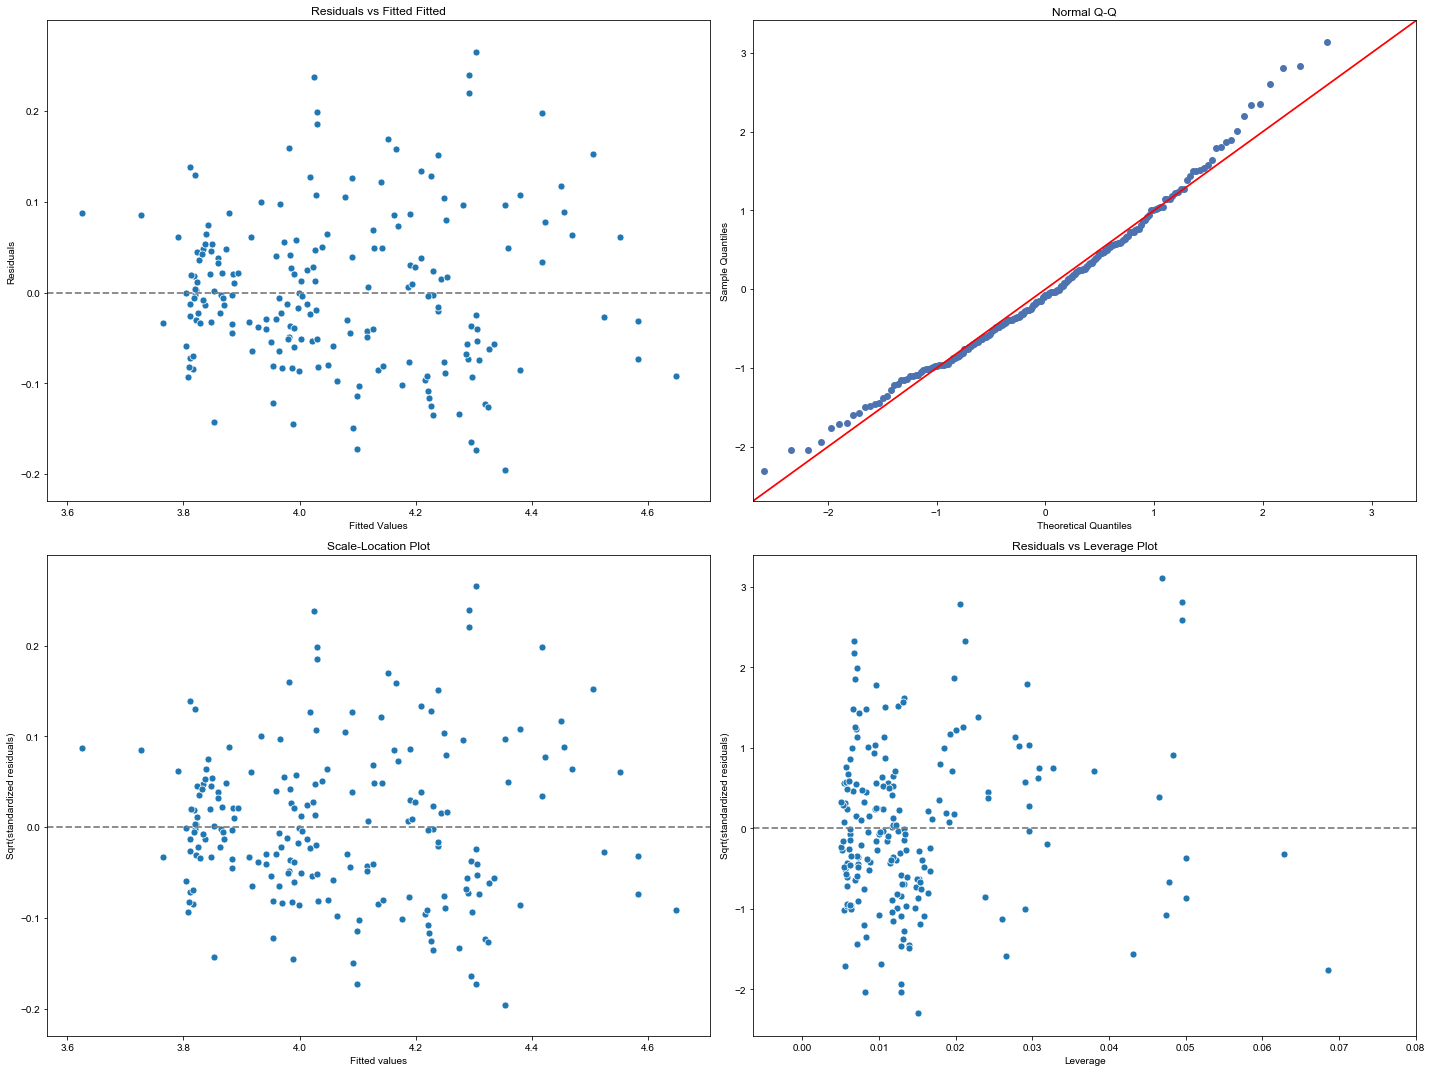

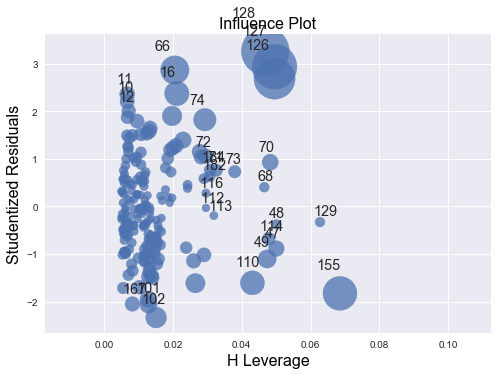

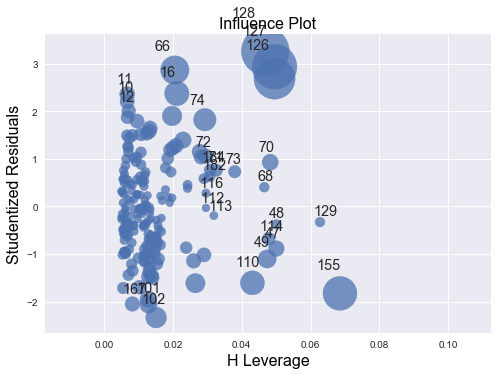

In [64]:
results = model
# Get different Variables for diagnostic
residuals = results.resid
fitted_value = results.fittedvalues
stand_resids = results.resid_pearson
influence = results.get_influence()
leverage = influence.hat_matrix_diag
  
# PLot different diagnostic plots
plt.rcParams["figure.figsize"] = (20,15)
fig, ax = plt.subplots(nrows=2, ncols=2)
  
plt.style.use('seaborn')
  
# Residual vs Fitted Plot
sns.scatterplot(x=fitted_value, y=residuals, ax=ax[0, 0])
ax[0, 0].axhline(y=0, color='grey', linestyle='dashed')
ax[0, 0].set_xlabel('Fitted Values')
ax[0, 0].set_ylabel('Residuals')
ax[0, 0].set_title('Residuals vs Fitted Fitted')
  
# Normal Q-Q plot
sm.qqplot(residuals, fit=True, line='45',ax=ax[0, 1], c='#4C72B0')
ax[0, 1].set_title('Normal Q-Q')
  
# Scale-Location Plot
sns.scatterplot(x=fitted_value, y=residuals, ax=ax[1, 0])
ax[1, 0].axhline(y=0, color='grey', linestyle='dashed')
ax[1, 0].set_xlabel('Fitted values')
ax[1, 0].set_ylabel('Sqrt(standardized residuals)')
ax[1, 0].set_title('Scale-Location Plot')
  
# Residual vs Leverage Plot
sns.scatterplot(x=leverage, y=stand_resids, ax=ax[1, 1])
ax[1, 1].axhline(y=0, color='grey', linestyle='dashed')
ax[1, 1].set_xlabel('Leverage')
ax[1, 1].set_ylabel('Sqrt(standardized residuals)')
ax[1, 1].set_title('Residuals vs Leverage Plot')
  
  
plt.tight_layout()
plt.show()
  
# PLot Cook's distance plot
sm.graphics.influence_plot(results, criterion="cooks")

In [65]:
df.iloc[126:129,:]

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
126,127,3,porcshce panamera,gas,std,two,hardtop,rwd,rear,89.5,168.9,65.0,51.6,2756,ohcf,six,194,mpfi,3.74,2.9,9.5,207,5900,17,25,32528.0
127,128,3,porsche cayenne,gas,std,two,hardtop,rwd,rear,89.5,168.9,65.0,51.6,2756,ohcf,six,194,mpfi,3.74,2.9,9.5,207,5900,17,25,34028.0
128,129,3,porsche boxter,gas,std,two,convertible,rwd,rear,89.5,168.9,65.0,51.6,2800,ohcf,six,194,mpfi,3.74,2.9,9.5,207,5900,17,25,37028.0


In [66]:
dfm.columns

Index(['wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight',
       'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
       'peakrpm', 'citympg', 'highwaympg', 'price', 'symboling_-2',
       'symboling_0', 'symboling_1', 'symboling_2', 'symboling_3',
       'CarName_audi', 'CarName_bmw', 'CarName_buick', 'CarName_chevrolet',
       'CarName_dodge', 'CarName_honda', 'CarName_isuzu', 'CarName_jaguar',
       'CarName_mazda', 'CarName_mercury', 'CarName_mitsubishi',
       'CarName_nissan', 'CarName_peugeot', 'CarName_plymouth',
       'CarName_porsche', 'CarName_renault', 'CarName_saab', 'CarName_subaru',
       'CarName_toyota', 'CarName_volkswagen', 'CarName_volvo', 'fueltype_gas',
       'aspiration_turbo', 'doornumber_two', 'carbody_hardtop',
       'carbody_hatchback', 'carbody_sedan', 'carbody_wagon', 'drivewheel_fwd',
       'drivewheel_rwd', 'enginetype_dohcv', 'enginetype_l', 'enginetype_ohc',
       'enginetype_ohcf', 'enginetype_ohcv', 'engine

In [67]:
X = dfm[['curbweight','horsepower',
       'symboling_-2', 'symboling_0', 'symboling_1', 'symboling_2',
       'symboling_3', 'CarName_audi', 'CarName_bmw',
       'CarName_buick', 'CarName_chevrolet', 'CarName_dodge', 'CarName_honda',
       'CarName_isuzu', 'CarName_jaguar', 'CarName_mazda', 'CarName_mercury',
       'CarName_mitsubishi', 'CarName_nissan', 'CarName_peugeot',
       'CarName_plymouth', 'CarName_porsche', 'CarName_renault',
       'CarName_saab', 'CarName_subaru', 'CarName_toyota',
       'CarName_volkswagen', 'CarName_volvo',
       'fueltype_gas', 'aspiration_turbo',
       'doornumber_two', 'carbody_hardtop',
       'carbody_hatchback', 'carbody_sedan', 'carbody_wagon',
       'drivewheel_fwd', 'drivewheel_rwd',
       'enginetype_dohcv', 'enginetype_l', 'enginetype_ohc', 'enginetype_ohcf',
       'enginetype_ohcv', 'enginetype_rotor',
       'cylindernumber_five', 'cylindernumber_four', 'cylindernumber_six',
       'cylindernumber_three', 'cylindernumber_twelve', 'cylindernumber_two',
         'fuelsystem_2bbl', 'fuelsystem_4bbl',
       'fuelsystem_idi', 'fuelsystem_mfi', 'fuelsystem_mpfi',
       'fuelsystem_spdi', 'fuelsystem_spfi']]
X = sm.add_constant(X)
X['log10 horsepower'] = np.log10(X['horsepower'])
X = X.drop('horsepower', axis = 1)

In [68]:
get_stats()

                            OLS Regression Results                            
Dep. Variable:            log10 price   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     66.69
Date:                Mon, 29 May 2023   Prob (F-statistic):           3.37e-82
Time:                        13:37:01   Log-Likelihood:                 348.62
No. Observations:                 205   AIC:                            -589.2
Df Residuals:                     151   BIC:                            -409.8
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     2.21

In [69]:
X = dfm[['curbweight','horsepower','symboling_-2','CarName_bmw','CarName_mitsubishi','CarName_peugeot',
         'CarName_plymouth','CarName_subaru','CarName_toyota','fueltype_gas','carbody_hatchback',
         'carbody_wagon','enginetype_ohcf','cylindernumber_five','fuelsystem_idi','fuelsystem_mpfi']]
X = sm.add_constant(X)
X['log10 horsepower'] = np.log10(X['horsepower'])
X = X.drop('horsepower', axis = 1)

In [70]:
get_stats()

                            OLS Regression Results                            
Dep. Variable:            log10 price   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     175.8
Date:                Mon, 29 May 2023   Prob (F-statistic):          2.97e-102
Time:                        13:37:01   Log-Likelihood:                 298.39
No. Observations:                 205   AIC:                            -564.8
Df Residuals:                     189   BIC:                            -511.6
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.8649    

In [71]:
X = dfm[['curbweight','horsepower','symboling_-2','CarName_bmw','CarName_mitsubishi','CarName_peugeot',
         'CarName_plymouth','CarName_subaru','CarName_toyota','fueltype_gas','carbody_hatchback',
         'carbody_wagon','enginetype_ohcf','fuelsystem_idi','fuelsystem_mpfi']]
X = sm.add_constant(X)
X['log10 horsepower'] = np.log10(X['horsepower'])
X = X.drop('horsepower', axis = 1)
get_stats()

                            OLS Regression Results                            
Dep. Variable:            log10 price   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     184.2
Date:                Mon, 29 May 2023   Prob (F-statistic):          2.38e-102
Time:                        13:37:01   Log-Likelihood:                 295.77
No. Observations:                 205   AIC:                            -561.5
Df Residuals:                     190   BIC:                            -511.7
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.8699      0

In [72]:
X = X.drop('symboling_-2',axis = 1)
get_stats()

                            OLS Regression Results                            
Dep. Variable:            log10 price   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     196.8
Date:                Mon, 29 May 2023   Prob (F-statistic):          5.45e-103
Time:                        13:37:01   Log-Likelihood:                 294.48
No. Observations:                 205   AIC:                            -561.0
Df Residuals:                     191   BIC:                            -514.4
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.8660      0

In [73]:
X = X.drop('carbody_hatchback',axis = 1)
get_stats()

                            OLS Regression Results                            
Dep. Variable:            log10 price   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     211.9
Date:                Mon, 29 May 2023   Prob (F-statistic):          1.00e-103
Time:                        13:37:01   Log-Likelihood:                 293.39
No. Observations:                 205   AIC:                            -560.8
Df Residuals:                     192   BIC:                            -517.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.8870      0

In [74]:
X = X.drop('CarName_plymouth',axis = 1)
get_stats()

                            OLS Regression Results                            
Dep. Variable:            log10 price   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     226.3
Date:                Mon, 29 May 2023   Prob (F-statistic):          6.81e-104
Time:                        13:37:01   Log-Likelihood:                 290.88
No. Observations:                 205   AIC:                            -557.8
Df Residuals:                     193   BIC:                            -517.9
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.8970      0

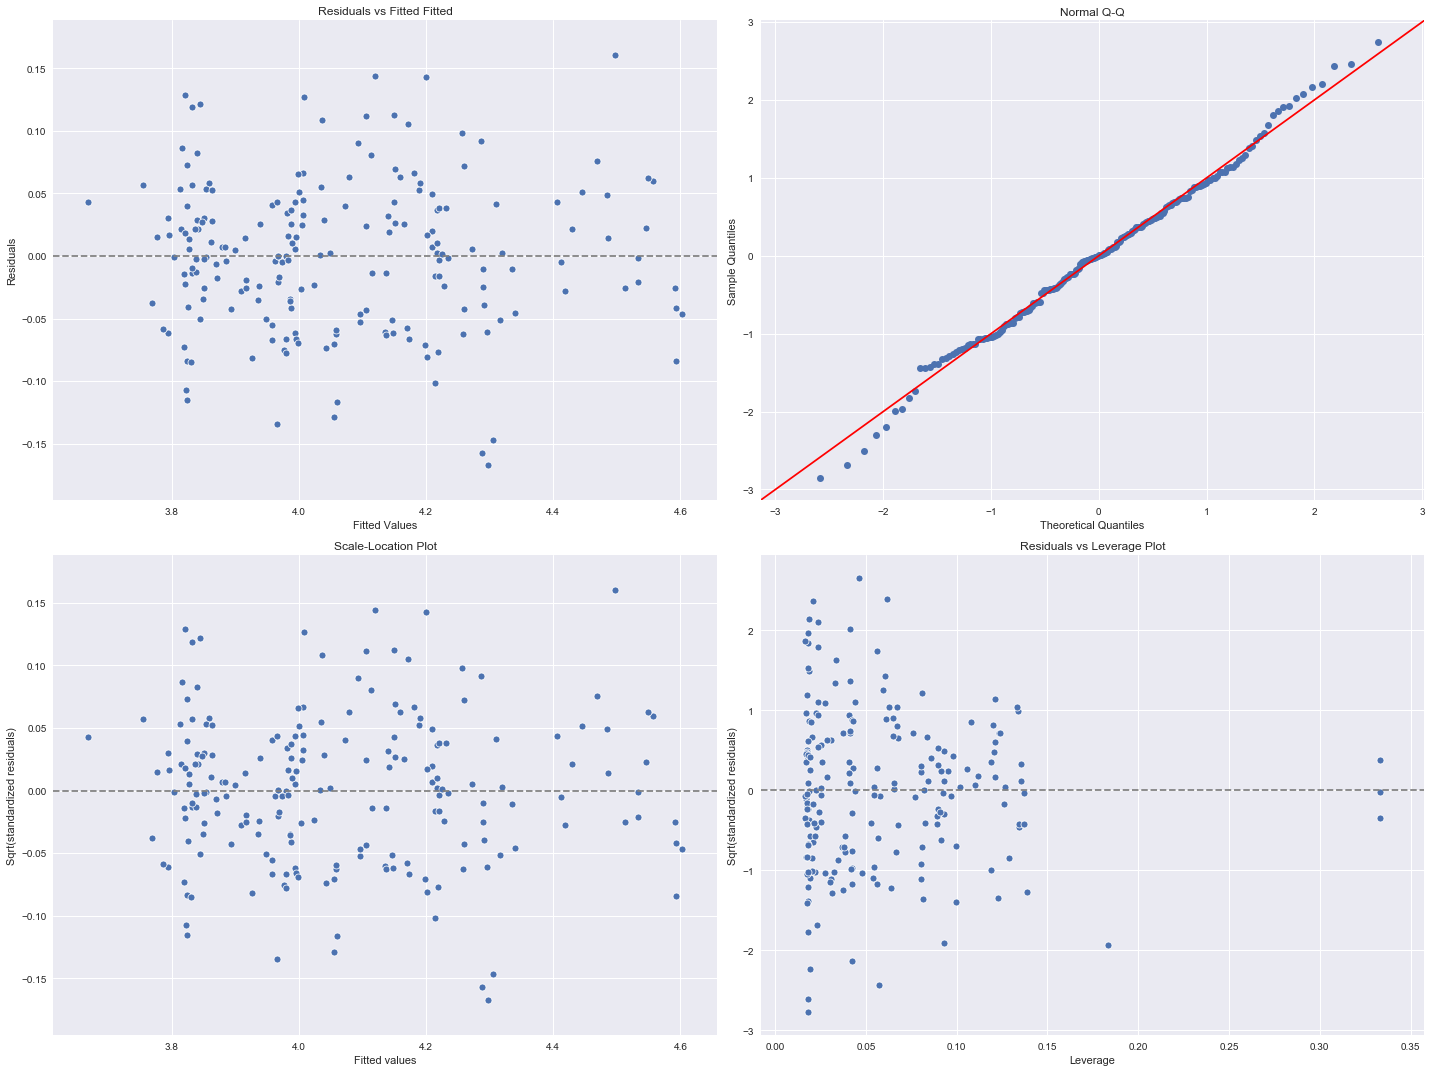

In [75]:
XMLR = X

model = sm.OLS(y, X).fit()
results = model
# Get different Variables for diagnostic
residuals = results.resid
fitted_value = results.fittedvalues
stand_resids = results.resid_pearson
influence = results.get_influence()
leverage = influence.hat_matrix_diag
  
# PLot different diagnostic plots
plt.rcParams["figure.figsize"] = (20,15)
fig, ax = plt.subplots(nrows=2, ncols=2)
  
plt.style.use('seaborn')
  
# Residual vs Fitted Plot
sns.scatterplot(x=fitted_value, y=residuals, ax=ax[0, 0])
ax[0, 0].axhline(y=0, color='grey', linestyle='dashed')
ax[0, 0].set_xlabel('Fitted Values')
ax[0, 0].set_ylabel('Residuals')
ax[0, 0].set_title('Residuals vs Fitted Fitted')
  
# Normal Q-Q plot
sm.qqplot(residuals, fit=True, line='45',ax=ax[0, 1], c='#4C72B0')
ax[0, 1].set_title('Normal Q-Q')
  
# Scale-Location Plot
sns.scatterplot(x=fitted_value, y=residuals, ax=ax[1, 0])
ax[1, 0].axhline(y=0, color='grey', linestyle='dashed')
ax[1, 0].set_xlabel('Fitted values')
ax[1, 0].set_ylabel('Sqrt(standardized residuals)')
ax[1, 0].set_title('Scale-Location Plot')
  
# Residual vs Leverage Plot
sns.scatterplot(x=leverage, y=stand_resids, ax=ax[1, 1])
ax[1, 1].axhline(y=0, color='grey', linestyle='dashed')
ax[1, 1].set_xlabel('Leverage')
ax[1, 1].set_ylabel('Sqrt(standardized residuals)')
ax[1, 1].set_title('Residuals vs Leverage Plot')
  
  
plt.tight_layout()
plt.show()

## This is our best model, adjusted R-squared of 0.924 and an AIC of -557.8

#### Create test and train datasets to find the accuracy of the above MLR model.

In [76]:
#Split data.

X = XMLR

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 30)
regr = linear_model.LinearRegression()

start1 = timer()

regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

end1 = timer()

MLR = round(metrics.r2_score(y_test, y_pred), 2)
print(regr)
print('RMSE = ', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),4))
print("R-squared score =", round(metrics.r2_score(y_test, y_pred), 2))
print("Explain variance score =", round(metrics.explained_variance_score(y_test, y_pred), 2))

#Use k-fold cross validation to assess the model
    

scores = cross_val_score(regr, X = X_train, y = y_train, cv = 10, n_jobs = 1)
print('K-fold cross validation score accuracy: ', np.round(np.mean(scores),3), '+/-', np.round(np.std(scores),3))

LinearRegression()
RMSE =  0.0627
R-squared score = 0.91
Explain variance score = 0.91
K-fold cross validation score accuracy:  0.905 +/- 0.063


# Random Forest Regrssion

In [77]:
#Include all variables in the first random forest regression.
regr = RandomForestRegressor(n_estimators=100)
X = dfm.drop(['price','log10 price'],axis=1)
y = dfm['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 30)


regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)


RFR = round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),4)
print(regr)
print('RMSE = ', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),4))
print("R-squared score =", round(metrics.r2_score(y_test, y_pred), 2))
print("Explain variance score =", round(metrics.explained_variance_score(y_test, y_pred), 2))

#Use k-fold cross validation to assess the model
    

scores = cross_val_score(regr, X = X_train, y = y_train, cv = 10, n_jobs = 1)
print('K-fold cross validation score accuracy: ', np.round(np.mean(scores),3), '+/-', np.round(np.std(scores),3))

RandomForestRegressor()
RMSE =  2063.0151
R-squared score = 0.92
Explain variance score = 0.92
K-fold cross validation score accuracy:  0.889 +/- 0.052


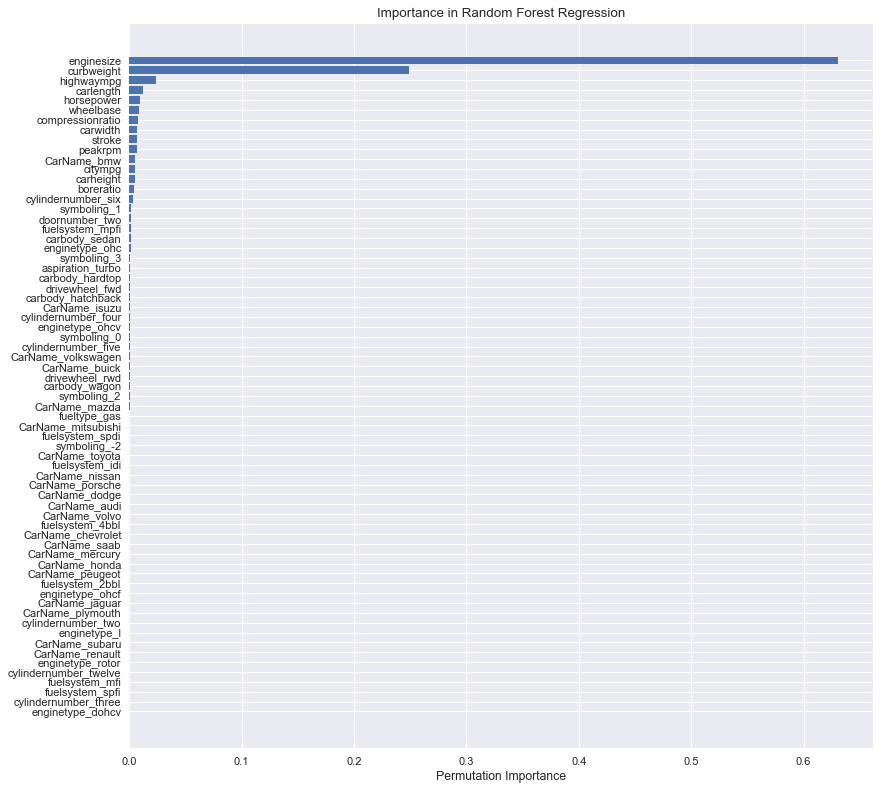

In [78]:
#Find importance of features.
feature_imp = pd.Series(regr.feature_importances_,X_train.columns).sort_values(ascending=False)

sorted_idx = regr.feature_importances_.argsort()
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(12,12),dpi=80)
plt.xlabel("Permutation Importance")
plt.barh(X_test.columns[sorted_idx], regr.feature_importances_[sorted_idx])
plt.title('Importance in Random Forest Regression')
plt.show()

In [79]:
#The following variables give the best accuracy 
X = dfm[['curbweight','enginesize','highwaympg','horsepower','carwidth','citympg','wheelbase']]

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 30)

start2 = timer()

regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

end2 = timer()

RFR = round(metrics.r2_score(y_test, y_pred), 2)
print(regr)
print('RMSE = ', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),4))
print("R-squared score =", round(metrics.r2_score(y_test, y_pred), 2))
print("Explain variance score =", round(metrics.explained_variance_score(y_test, y_pred), 2))

#Use k-fold cross validation to assess the model
    

scores = cross_val_score(regr, X = X_train, y = y_train, cv = 10, n_jobs = 1)
print('K-fold cross validation score accuracy: ', np.round(np.mean(scores),3), '+/-', np.round(np.std(scores),3))

RandomForestRegressor()
RMSE =  2111.7215
R-squared score = 0.92
Explain variance score = 0.92
K-fold cross validation score accuracy:  0.882 +/- 0.048


# PCA with MLR

In [81]:
dfp = df_cleaned.copy()

In [82]:
dfp = pd.get_dummies(dfp, drop_first = True)

In [83]:
X = dfp.drop('price',axis = 1)
y = np.log10(dfp['price'])

In [84]:
dfp_scaled = StandardScaler().fit_transform(X)
pca=PCA(n_components=30)
X_red = pca.fit_transform(dfp_scaled)

In [85]:
print('Shape before PCA: ', dfp_scaled.shape)
print('Shape after PCA: ', X_red.shape)

Shape before PCA:  (205, 67)
Shape after PCA:  (205, 30)


In [86]:
pca.explained_variance_

array([10.77759312,  5.91746592,  3.75749797,  3.53191483,  2.8316716 ,
        2.62027733,  2.31320684,  2.22728674,  2.00989983,  1.9595159 ,
        1.75546078,  1.71560291,  1.58966577,  1.56980996,  1.49182894,
        1.42186767,  1.39953562,  1.28175296,  1.22161472,  1.18057046,
        1.14669336,  1.09225284,  0.99354344,  0.95460078,  0.92877641,
        0.87834736,  0.84203378,  0.76021676,  0.63302295,  0.62249005])

### Use the components with a value above 1

In [87]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals = 4)*100)[0:21]

array([16.01, 24.8 , 30.38, 35.63, 39.84, 43.73, 47.17, 50.48, 53.47,
       56.38, 58.99, 61.54, 63.9 , 66.23, 68.45, 70.56, 72.64, 74.54,
       76.35, 78.1 , 79.8 ])

### 79.8 % is explained by 22 components, reduced from 67 originally.

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 30)

In [89]:
X_red_train = pca.fit_transform(StandardScaler().fit_transform(X_train))
X_red_test = pca.transform(StandardScaler().fit_transform(X_test))[:,0:21]
lm = LinearRegression()

start3 = timer()

pcr = lm.fit(X_red_train[:,0:21], y_train)
y_pred = pcr.predict(X_red_test)

end3 = timer()

In [90]:
PC = round(metrics.r2_score(y_test, y_pred), 2)
print('RMSE: ', np.round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),4))
print("R-squared score =", round(metrics.r2_score(y_test, y_pred), 2))

RMSE:  0.0669
R-squared score = 0.89


# Evaluate accuracy and efficiency of all three models

In [91]:
print('Multiple Linear Regression R squared: ', MLR, 
      '\nRandom Forest Regression R squared: ', RFR, 
      '\nPrincipal Component Analysis R squared:', PC)


Multiple Linear Regression R squared:  0.91 
Random Forest Regression R squared:  0.92 
Principal Component Analysis R squared: 0.89


In [92]:
print('Time for Multiple Linear Regression: ', np.round(end1 - start1, 4), 's')
print('Time for Random Forest: ', np.round(end2 - start2, 4), 's')
print('Time for Principal Component Analysis: ', np.round(end3 - start3, 4), 's')

Time for Multiple Linear Regression:  0.0106 s
Time for Random Forest:  0.1998 s
Time for Principal Component Analysis:  0.0013 s


In [93]:
data = {'Method': ['Multiple Linear Regression','Random Forest Regression','Principal Component Analysis'],
        'R Squared score on test data': [MLR, RFR, PC],
        'Time (s)': [np.round(end1 - start1, 4), np.round(end2 - start2, 4), np.round(end3 - start3, 4)]}
df_final = pd.DataFrame(data=data)
df_final

,Method,R Squared score on test data,Time (s)
0,Multiple Linear Regression,0.91,0.0106
1,Random Forest Regression,0.92,0.1998
2,Principal Component Analysis,0.89,0.0013


# Final Remarks

### All three methods have similar accuracies after being tested on the same test data.
### Each method provides a good prediction for the price of a car.
### Random Forest is the most accurate but slow.
### PCA is a little less accurate but is 100 fold faster than Random Forest which may be important for a larger sample.
### MLR has good accuracy in a reasonable time. It is the best model to use.